### Building models

In [1]:
from pymgpipe import *
from pkg_resources import resource_filename

taxa_directory = resource_filename("pymgpipe", "resources/miniTaxa/")

# Generating random abundance matrix
taxa = [x.split('.xml.gz')[0] for x in os.listdir(taxa_directory)]
abundances = pd.DataFrame(np.random.randint(250,750,size=(4, 10)),columns=['sample_0'+str(i) for i in range(1,11)],index=taxa)
abundances = abundances.apply(lambda x: x/x.sum(),axis=0)
abundances

,sample_01,sample_02,sample_03,sample_04,sample_05,sample_06,sample_07,sample_08,sample_09,sample_010
TaxaD,0.255123,0.204819,0.174660,0.308862,0.357503,0.342088,0.187595,0.231042,0.208297,0.133891
TaxaB,0.283563,0.136546,0.320900,0.226009,0.154582,0.275421,0.323752,0.289135,0.318341,0.385983
TaxaA,0.249268,0.362450,0.270574,0.148401,0.359013,0.179798,0.147252,0.303326,0.268122,0.233264
TaxaC,0.212045,0.296185,0.233866,0.316728,0.128902,0.202694,0.341402,0.176497,0.205240,0.246862


Found coverage file with 10 samples and 4 unique taxa
Building 10 models...

----------------Parameters----------------
Diet/fecal compartments- TRUE
Coupling constraints- TRUE
Parallel- TRUE
Threads- 7
Solver- GUROBI
LP type- MPS
COBRA type- XML
compress- TRUE
Output directory- OUT/


  0%|          | 0/10 [00:00<?, ?it/s]pymgpipe.logger - INFO - Finished building mc1 in 0.01 minutes!
pymgpipe.logger - INFO - Finished building mc3 in 0.01 minutes!
pymgpipe.logger - INFO - Finished building mc7 in 0.01 minutes!
pymgpipe.logger - INFO - Finished building mc4 in 0.01 minutes!
pymgpipe.logger - INFO - Finished building mc8 in 0.01 minutes!
pymgpipe.logger - INFO - Finished building mc5 in 0.01 minutes!
pymgpipe.logger - INFO - Finished building mc6 in 0.02 minutes!
pymgpipe.logger - INFO - Removing variables from mc1...
pymgpipe.logger - INFO - Removing variables from mc4...
pymgpipe.logger - INFO - Removing variables from mc3...
pymgpipe.logger - INFO - Removing variables from mc7...
pymgpipe.logger - INFO - Removing variables from mc8...
pymgpipe.logger - INFO - Adding coupling constraints to mc1...
pymgpipe.logger - INFO - Adding coupling constraints to mc4...
pymgpipe.logger - INFO - Removing variables from mc5...
pymgpipe.logger - INFO - Adding coupling constraints

-------------------------------------------------------


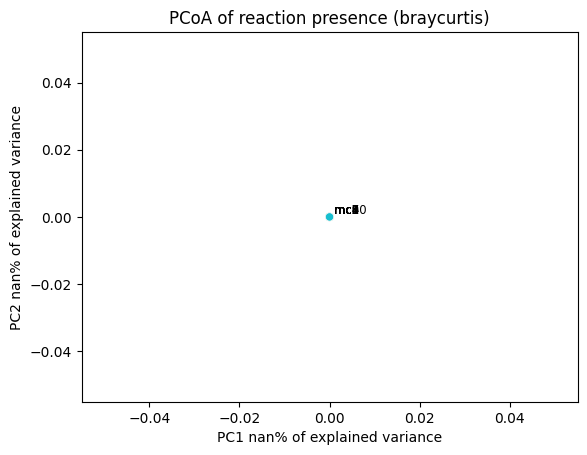

In [4]:
# ----- STEP 1: BUILD COMMUNITY MODELS ----
build_models(
    coverage_file=abundances,
    taxa_dir=taxa_directory,
    out_dir='out',
    diet_fecal_compartments=True,
    coupling_constraints=True,
    remove_reverse_vars_from_lp=True,
    hard_remove=True,
    compress=True,
    threads=-1,
    parallel=True,
    solver='gurobi',
    cobra_type='.xml',
    lp_type='.mps',
    compute_metrics=True,
    sample_prefix='mc',
    force=True,
    # diet='test_diet.csv', <-- you can try uncommenting this, however this diet will result in infeasibility
)

In [ ]:
# ----- STEP 1.2: BUILD INDIVIDUAL MODELS ----
my_model = build(
    abundances=abundances,
    sample='sample_03',
    taxa_directory=taxa_directory,
    diet_fecal_compartments=True
)
add_coupling_constraints(my_model)
solve_model(my_model)
write_lp_problem(my_model, 'my_model.mps')

### Simulating communities

In [ ]:
# ----- STEP 2: COMPUTE NMPCS ----
res = compute_nmpcs(
    samples='out/problems/',
    out_dir='out/',
    threshold=0,
    fva_type=FVA_TYPE.REGULAR,
    force=True,
    threads=-1,
    objective_percent=100,
    solver='gurobi'
)
res.nmpc

In [ ]:
# ----- STEP 2.2: COMPUTE NMPCS FOR INDIVIDUAL MODELS ----
res = compute_nmpcs(
    samples=my_model,
    write_to_file=False
)
res.nmpc

### Optional- working with optlang models

In [ ]:
from pymgpipe import *

# To load a model, you can do either of the following. Either one will return the underlying optlang LP problem
# Note, anywhere you see a `model` parameter in a function, you can provide either the optlang object or the path to the file

model = load_model('out/models/mc1.xml.gz', solver='cplex') # <-- Note, this is the COBRA model, and thus will not have any modifications you have made to the underlying lp (i.e. coupling constraints, diet, removing reverse variables, etc)

# OR

model = load_model('out/problems/mc1.mps.gz', solver='gurobi') # <-- This WILL have those modifications. It is recommended to always work with the models in the problems/ folder
print(model.objective)

In [ ]:
# Adding diets (remember, depending on the model, some diets will result in model infeasibility)

print(get_available_diets())

add_diet_to_model(model,'GlutenFreeDiet', force_uptake=False)
print(get_diet(model))

In [ ]:
# You can also add a diet directly from a file 

add_diet_to_model(model, 'test_diet.csv')
print(get_diet(model))

In [ ]:
# Removing diets 

remove_diet(model)
print(get_diet(model))

In [ ]:
# Adding coupling constraints

add_coupling_constraints(model)

In [ ]:
# Removing coupling constraints 

remove_coupling_constraints(model)

In [ ]:
# Removing reverse variables (this is recommended if model size is an issue)
# Setting hard_remove to TRUE will remove the reverse variables from the model entirely (removing the variables can be time consuming)
# Setting hard_remove to FALSE will keep the reverse variables in place, but set their bounds to zero (this is done to save time)

remove_reverse_vars(model, hard_remove=True)

In [ ]:
# Fetching reactions of interest 

exchange_reactions = get_reactions(model, regex='EX_.*[fe]')
print(exchange_reactions)

smaller_subset = get_reactions(model, reactions=exchange_reactions[:5])
print(smaller_subset)

In [ ]:
# Setting objectives (remember, if you haven't removed reverse variables, you will need to make to include them in any objective you set, where NET FLUX = forward - reverse)

set_objective(model, obj_expression=np.sum(smaller_subset),direction='min')
print(model.objective)

solve_model(model)

In [ ]:
# Running FVA

add_coupling_constraints(model)
set_objective(model, 'communityBiomass', 'max')

res = fva(
    model,
    reactions = exchange_reactions,
    threads = -1,
    fva_type=FVA_TYPE.REGULAR,
    objective_percent=100
)
res

In [ ]:
# If you have VFFVA installed, you can run FVA like so
# Note, VFFVA requires the `model` parameter to be an .mps file, so make sure that your desired objective is set before running this function

vffva_config.path = '/Users/yolimeydan/Documents/Columbia/VFFVA/'
res = fva(
    model='out/problems/mc1.mps.gz',
    solver='cplex',
    reactions = exchange_reactions,
    threads = -1,
    fva_type=FVA_TYPE.FAST,
    objective_percent=100
)
res